# Modeling

**Goal**

Build a Machine Learning model capable to classify whether students are under lagging (defasagem) risk and the severity of it. 
The classification will work as follows:

- **Critical (`0`):** `target_defasagem` ≤ -2
- **Alert (`1`):** `target_defasagem` = -1
- **Expected (`2`):** `target_defasagem` ≥ 0

**Data**

According to the <a href="https://drive.google.com/drive/folders/1Z1j6uzzCOgjB2a6i3Ym1pmJRsasfm7cD">original source</a>, the table below provides a dictionary outlining what each column in the dataset represents.


| Column Name | Meaning / Business Logic |
| :--- | :--- |
| **RA** | Unique student registration identifier (Registro do Aluno) |
| **ano_dados** | The reference year for the recorded data points |
| **fase** | The student's current learning level or phase. |
| **idade** | The age of the student in the reference year. |
| **genero** | Student's gender (demographic feature). |
| **anos_na_instituicao** | Duration (in years) the student has been part of Passos Mágicos. |
| **instituicao** | Type of educational institution the student attends (e.g., Public, Scholarship). |
| **pedra_atual** | Classification based on INDE score: Quartzo (2.4-5.5), Ágata (5.5-6.8), Ametista (6.8-8.2), or Topázio (8.2-9.2). |
| **inde_atual** | Educational Development Index: A weighted average of indicators (IAN, IDA, IEG, IAA, IPS, IPP, and IPV). |
| **indicador_auto_avaliacao** | **(IAA)**: Average of student self-assessment scores. |
| **indicador_engajamento** | **(IEG)**: Average of student engagement scores. |
| **indicador_psicossocial** | **(IPS)**: Average of student psychosocial assessment scores. |
| **indicador_aprendizagem** | **(IDA)**: Average of learning performance scores. |
| **indicador_ponto_virada** | **(IPV)**: Average score evaluating if the student reached the "Turning Point" milestone. |
| **indicador_adequacao_nivel** | **(IAN)**: Average score for student suitability for their current educational level. |
| **indicador_psico_pedagogico** | **(IPP)**: Average score of psychopedagogical evaluations. |
| **defasagem** | Current academic gap level recorded for the student. |
| **target_defasagem** | Shifted target variable for predictive modeling. |

### Table of Contents
1. [Loading Data](#loading-data)
2. [Feature Engineering](#feature-engineering)
    * 2.1 [Target Variable](#target-variable)
    * 2.2 [Independent Variables](#independent-variables)
3. [Baseline](#baseline)
4. [Ensemble Models](#ensemble-models)
5. [Feature Importance](#feature-importance)
6. [Saving Models](#saving-models)

## Loading Data

In [1]:
import pandas as pd
import numpy as np
import joblib
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

seed=42

In [2]:
# Defining functions for Load and Describe Data
def display_feature_list(features, feature_type):
    '''
    This function displays the features within each list for each type of data
    '''

    print(f"\n{feature_type} Features: ")
    print(', '.join(features) if features else 'None')


def describe_df(df):
    """
    This function prints some basic info on the dataset and 
    sets global variables for feature lists.
    """

    global categorical_features, continuous_features, binary_features
    categorical_features = [
        col for col in df.columns if not pd.api.types.is_numeric_dtype(df[col])
    ]
    
    binary_features = [col for col in df.columns if df[col].nunique(
    ) <= 2 and df[col].dtype != 'object']
    continuous_features = [
        col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])
    ]

    print(f"\n{type(df).__name__} shape: {df.shape}")
    print(f"\n{df.shape[0]:,.0f} samples")
    print(f"\n{df.shape[1]:,.0f} attributes")
    display_feature_list(categorical_features, 'Categorical')
    display_feature_list(continuous_features, 'Continuous')
    display_feature_list(binary_features, 'Binary (0 or 1)')
    print(f'\nData Types: \n{df.dtypes}')
    print(
        f'\nMissing Data Percentage: \n{(df.isnull().sum() / len(df) * 100).round(2).astype(str) + "%"}')
    print(f'\nDuplicates: {df.duplicated().sum()}')
    print(
        f'\nCategorical Feature Cardinality: \n{df[categorical_features].nunique().sort_values(ascending=False)}')
    print(
        f'\nFeatures with Zero Variance: {", ".join([col for col in df.columns if df[col].nunique() == 1]) if any(df[col].nunique() == 1 for col in df.columns) else "None"}')

    negative_valued_features = [
        col for col in df[continuous_features] if (df[col] < 0).any()]
    print(
        f'\nFeatures with Negative Values: {", ".join(negative_valued_features) if negative_valued_features else "None"}')

    print('\nStatistical Summary: \n')
    display(df.describe().T)
    print(f'\n{type(df).__name__} Head: \n')
    display(df.head(5))
    print(f'\n{type(df).__name__} Tail: \n')
    display(df.tail(5))

In [3]:
df = pd.read_parquet('../data/03_gold/train_data.parquet')
describe_df(df)


DataFrame shape: (1369, 18)

1,369 samples

18 attributes

Categorical Features: 
genero, instituicao, pedra_atual

Continuous Features: 
RA, ano_dados, fase, idade, anos_na_instituicao, inde_atual, indicador_auto_avaliacao, indicador_engajamento, indicador_psicossocial, indicador_aprendizagem, indicador_ponto_virada, indicador_adequacao_nivel, indicador_psico_pedagogico, defasagem, target_defasagem

Binary (0 or 1) Features: 
ano_dados

Data Types: 
RA                              int64
ano_dados                       int64
fase                            int64
idade                           int64
genero                         object
anos_na_instituicao             int64
instituicao                    object
pedra_atual                    object
inde_atual                    float64
indicador_auto_avaliacao      float64
indicador_engajamento         float64
indicador_psicossocial        float64
indicador_aprendizagem        float64
indicador_ponto_virada        float64
indicador_ad

,count,mean,std,min,25%,50%,75%,max
RA,1369.0,589.017531,338.601859,1.000,318.000000,588.000000,827.000000,1274.000000
ano_dados,1369.0,2022.558802,0.496712,2022.000,2022.000000,2023.000000,2023.000000,2023.000000
fase,1369.0,2.265888,2.135268,0.000,1.000000,2.000000,3.000000,8.000000
idade,1369.0,12.094229,3.092252,7.000,10.000000,12.000000,14.000000,26.000000
anos_na_instituicao,1369.0,1.660336,1.866733,0.000,0.000000,1.000000,3.000000,7.000000
inde_atual,1294.0,7.360993,0.884275,3.032,6.797906,7.453396,7.984606,9.442000
indicador_auto_avaliacao,1310.0,7.656794,2.990752,0.000,7.800000,8.800000,9.500000,10.000000
indicador_engajamento,1297.0,8.593678,1.226611,0.000,8.100000,8.900000,9.500000,10.000000
indicador_psicossocial,1307.0,5.962119,1.910637,2.500,5.000000,6.900000,7.500000,10.000000
indicador_aprendizagem,1297.0,6.653816,1.694737,1.000,5.700000,6.800000,7.900000,10.000000



DataFrame Head: 



,RA,ano_dados,fase,idade,genero,anos_na_instituicao,instituicao,pedra_atual,inde_atual,indicador_auto_avaliacao,indicador_engajamento,indicador_psicossocial,indicador_aprendizagem,indicador_ponto_virada,indicador_adequacao_nivel,indicador_psico_pedagogico,defasagem,target_defasagem
0,1,2022,7,19,F,6,Pública,Quartzo,5.783,8.3,4.1,5.6,4.0,7.278,5.0,8.174,-1,0.0
1,1,2023,8,20,F,7,Bolsista,None,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,0,0.0
2,2,2022,7,17,F,5,Privada,Ametista,7.055,8.8,5.2,6.3,6.8,6.778,10.0,7.894,0,0.0
3,2,2023,8,18,F,6,Bolsista,None,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,0,0.0
4,5,2022,7,17,F,6,Privada,Ametista,7.427,7.9,8.6,5.6,5.2,7.389,10.0,8.392,0,0.0



DataFrame Tail: 



,RA,ano_dados,fase,idade,genero,anos_na_instituicao,instituicao,pedra_atual,inde_atual,indicador_auto_avaliacao,indicador_engajamento,indicador_psicossocial,indicador_aprendizagem,indicador_ponto_virada,indicador_adequacao_nivel,indicador_psico_pedagogico,defasagem,target_defasagem
1364,1270,2023,8,19,F,2,Bolsista,None,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,0,0.0
1365,1271,2023,8,18,F,2,Bolsista,None,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,0,0.0
1366,1272,2023,8,18,F,2,Bolsista,None,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,0,0.0
1367,1273,2023,8,17,F,0,Bolsista,None,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,1,0.0
1368,1274,2023,8,18,F,2,Bolsista,None,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,0,0.0


## Feature Engineering

### Target Variable

Since we have multiple values in our target variable, we'll create a new `target_class` variable where *defasagem* will be categorized into three distinct values: `critical`, `alert`, and `expected`. 
Students who are **2 or more years** behind will be put into `critical` category, whereas students **1 year** behind will be put into the `alert` category. Those who are not lagging behing will receieve the `expected` label. 

### Independent Variables

**Null Values**

For this specific experiment, we opted to remove `NaN`s instead of inputing values onto them. The reason why is because students from *fase 8* all have null values within their indicator features, including INDE and Pedra. It wouldn't be possible to accurately infer values for these students. 

**Categorical Features**

We will encode categorical features. A simple binary encoding for `genero` will work, where `male == 1` and `female == 0`. For `instituicao`, we will use a simple `OneHotEncoding` method, since there are no ranking or order between institutions.

**Multicollinearity**

During EDA, we noticed a high correlation between `inde_atual` and the cateogorical feature `pedra_atual`. We will drop `pedra_atual` and maintain the continuous `inde_atual` feature as it might contain more signal for our predictive models. 
We're also going to build **two pipelines**. One where we maintain INDE and remove individual indicators, and other where we remove INDE and keep indicators. 

**Outliers**

Indicators are bound to 0-10 range, which makes sense. Some values are beyond these limits, such as one -0.07 value in `indicador_psico_pedagogico` and a 10.01 in `indicador_ponto_virada`. We will clip these values so that they fit within the range. 


In [4]:
# Target Variable 
def create_target_class(y):
    """
    This function categorizes target_defasagem according to the following:

        - target_defasagem ≤ -2: critical (0)
        - target_defasagem = -1: alert (1)
        - target_defasagem ≥ 0: expected (2)
    """
    if y <= -2: return 0
    if y == -1: return 1
    return 2

In [5]:
# Clipping outliers
def clip_indicators(X):
    "Clip indicators to [0,10]"
    X_clipped = X.copy()
    
    indicators = [c for c in X.columns if 'indicador_' in c]
    X_clipped[indicators] = X_clipped[indicators].clip(0,10)
    return X_clipped

Clipper = FunctionTransformer(clip_indicators, validate=False)

In [ ]:
# <-- Preparing data -->

# Removing NaNs
df_clean = df.dropna().copy()

# Creating target class
df_clean['target_class'] = df_clean['target_defasagem'].apply(create_target_class)

# Target <> Features separation
X = df_clean.drop(columns=['defasagem', 'target_defasagem', 'pedra_atual', 'target_class'])
y = df_clean['target_class']

## Baseline

We'll start with a simple `LogisticRegression` model. 
Besides accuracy, we're also going to use the **F1 Macro** metric to assess performance, since we're dealing with unbalanced data (we have more `2` target class than `0`, for example)


In [7]:
# Defining model
baseline_model = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',
    random_state=seed
)

In [8]:
# <--- Building Pipelines --->

X['genero'] = X['genero'].map({'F': 0, 'M': 1})
all_cols = X.columns.to_list()
cat_features = ['instituicao']
num_features_all = [c for c in all_cols if c not in cat_features + ['RA', 'ano_dados']]

# SET A
## Keep INDE, drop individual indicators
features_A_num = [c for c in num_features_all if 'indicador_' not in c] 

# SET B
## Drop INDE and keep individual indicators
features_B_num = [c for c in num_features_all if c != 'inde_atual'] 

# --- Column Transformers ---
# Processing Categorical Features
cat_transformer = OneHotEncoder(
    sparse_output=False,
    handle_unknown='ignore'
)

# Preprocessor A: INDE
preprocessor_A = ColumnTransformer(
    transformers=[
        ('num', Clipper, features_A_num),
        ('cat', cat_transformer, cat_features)
    ],
    remainder='drop'
)

# Preprocessor B: Indicators
preprocessor_B = ColumnTransformer(
    transformers=[
        ('num', Clipper, features_B_num),
        ('cat', cat_transformer, cat_features)
    ],
    remainder='drop'
)

pipeline_A = Pipeline(
    steps=[
        ('preprocessor', preprocessor_A),
        ('classifier', baseline_model)
    ]
)

pipeline_B = Pipeline(
    steps=[
        ('preprocessor', preprocessor_B),
        ('classifier', baseline_model)
    ]
)

In [9]:
# Temporal Data Split

mask_train = X['ano_dados'] == 2022
mask_test = X['ano_dados'] == 2023

# Train on 2022 data
X_train, y_train = X[mask_train].copy(), y[mask_train].copy()

# Test on 2023 data
X_test, y_test = X[mask_test].copy(), y[mask_test].copy()

print('- - - Datasets Shape - - -\n')
print(f"Training set (2022): {X_train.shape}")
print(f"Testing set (2023): {X_test.shape}")
print('-'*50)
print('Value Counts\n')
print('Training Set: \n\n', y_train.value_counts(normalize=True))
print('\n')
print('Testing Set: \n\n', y_test.value_counts(normalize=True))
print('-'*50)

- - - Datasets Shape - - -

Training set (2022): (604, 15)
Testing set (2023): (690, 15)
--------------------------------------------------
Value Counts

Training Set: 

 target_class
1    0.438742
2    0.392384
0    0.168874
Name: proportion, dtype: float64


Testing Set: 

 target_class
2    0.557971
1    0.360870
0    0.081159
Name: proportion, dtype: float64
--------------------------------------------------


In [10]:
def fit_and_evaluate(pipeline, name='Model'):
    """
    Fit and evalute a ML pipeline
    
    Args:
        pipeline(sklearn.pipeline.Pipeline): Machine Learning pipeline to evaluate
        name(str): Name of the pipeline
    """

    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print(f"\n--- {name} Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Macro: {f1:.4f}")
    print('Classification Report:\n', classification_report(y_test, y_pred))
    print("-" * 30)

    return pipeline

In [11]:
print(f"Running Pipeline A (INDE)")
print("\n")
pipeline_A_results = fit_and_evaluate(pipeline_A, name="Pipeline A (INDE)")
print("-"*50)
print(f"Running Pipeline B (Indicators)")
print("\n")
pipeline_B_results = fit_and_evaluate(pipeline_B, name="Pipeline B (Indicators)")

Running Pipeline A (INDE)



--- Pipeline A (INDE) Results ---
Accuracy: 0.5696
F1 Macro: 0.4962
Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.61      0.37        56
           1       0.45      0.36      0.40       249
           2       0.74      0.70      0.72       385

    accuracy                           0.57       690
   macro avg       0.49      0.56      0.50       690
weighted avg       0.60      0.57      0.58       690

------------------------------
--------------------------------------------------
Running Pipeline B (Indicators)



--- Pipeline B (Indicators) Results ---
Accuracy: 0.6130
F1 Macro: 0.4666
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.43      0.34        56
           1       0.57      0.19      0.28       249
           2       0.67      0.91      0.78       385

    accuracy                           0.61       690
   macro av

**Baseline Conclusion**

Considering the class imbalance, the F1 macro average score is the most appropriate metric to evaluate our models.
In this case, **Pipeline A**, with `inde_atual` as a feature, performs better. 
By analyzing the **Recall**, we can also see that **Pipeline A** could more effectively capture students who under critical risk (`0`). Although false positives are high, this is a better trade-off than false negatives, which would be more damaging to the students' academic lives. 

Let's test more robust models with **Pipeline A**.

## Ensemble Models

After building a Baseline, we can train and test more robust models. 
The models chosen are:

- `RandomForestClassifier`
- `XGBClassifier`
- `LGBMClassifier`

We choose these models because these are ensemble tree-based models that tend to perform very well on tabular data and are very reliable on unscaled features and non-linear relationships

In [12]:
# <--- Building More Robust Models --->

# RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_leaf=2,
    random_state=seed,
    n_jobs=-1,
    class_weight="balanced",
)

pipeline_rf = Pipeline(
    steps=[
        ("preprocessor", preprocessor_A),
        ("classifier", rf_model),
    ]
)

# XGBoostClassifier
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_leaf=2,
    random_state=seed,
    n_jobs=-1,
    objective="multi:softprob",
    eval_metric="mlogloss",
    learning_rate=0.05,
)

pipeline_xgb = Pipeline(
    steps=[
        ("preprocessor", preprocessor_A),
        ("classifier", xgb_model),
    ]
)

# LightGBMClassifier
lgbm_model = LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    num_leaves=31,
    min_child_samples=10,
    random_state=seed,
    n_jobs=-1,
    class_weight="balanced",
    verbosity=-1,
    objective="multiclass",
)

pipeline_lgbm = Pipeline(
    steps=[
        ("preprocessor", preprocessor_A),
        ("classifier", lgbm_model),
    ]
)

In [13]:
print("<--- Running Models --->")
print("\n")
print("Running Random Forest...")
rf_results = fit_and_evaluate(pipeline_rf, name='Random Forest')
print("\n")
print("Running XGBoost...")
xgb_results = fit_and_evaluate(pipeline_xgb, name='XGBoost')
print('\n')
print('Running LightGBM...')
lgb_results = fit_and_evaluate(pipeline_lgbm, name='LightGBM')
print('-' * 50)

<--- Running Models --->


Running Random Forest...

--- Random Forest Results ---
Accuracy: 0.5971
F1 Macro: 0.5506
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.71      0.44        56
           1       0.47      0.51      0.49       249
           2       0.82      0.64      0.72       385

    accuracy                           0.60       690
   macro avg       0.54      0.62      0.55       690
weighted avg       0.66      0.60      0.61       690

------------------------------


Running XGBoost...

--- XGBoost Results ---
Accuracy: 0.6058
F1 Macro: 0.5575
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.55      0.44        56
           1       0.48      0.59      0.53       249
           2       0.80      0.63      0.70       385

    accuracy                           0.61       690
   macro avg       0.55      0.59      0.56       690
weighted avg     

**Robust Models Conclusions**


All three models achieved higher F1 Macro than the baseline.The three models have a somewhat similar performance, with F1 Macro around **0.55**.

It's noteworhty that while the baseline has a very low Recall on the `1` class, the ensemble models show a much better performance in identifying students who are under `alert` mode for lagging behind.

The `RandomForestClassifier` captures the most number of students under critical conditions `0`. Although it has higher levels of false positives, we choose to prefer higher recall, since we consider it's more important to identify the highest possible number of students under critical risk, to help them develop strategies to avoid lagging behind. 


## Feature Importance

In [14]:
def get_feature_names(pipeline):
    """
    Extract feature names from a fitted sklearn pipeline with a ColumnTransformer.
    Handles OneHotEncoder and simple pass-through/function transformers.
    """
    preprocessor = pipeline.named_steps['preprocessor']
    output_features = []

    for name, transformer, columns in preprocessor.transformers_:
        if name == 'remainder':
            continue
            
        if hasattr(transformer, 'get_feature_names_out'):
            output_features.extend(transformer.get_feature_names_out(columns))
        elif hasattr(transformer, 'get_feature_names'):
            output_features.extend(transformer.get_feature_names(columns))
            
        else:
            output_features.extend(columns)
            
    return output_features

def plot_feature_importance(pipelines: dict):
    """
    Plots feature importance for multiple fitted pipelines side by side,
    normalizing all values to relative importance (0-1) for comparison.

    Args:
        - pipelines(dict): Dictionary of pipelines and their names
    """
    n = len(pipelines)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 6), sharey=True)
    
    if n == 1:
        axes = [axes]
    
    colors = ['#3498DB', '#9B59B6', '#2ECC71', '#E74C3C']
    
    for ax, (name, pipeline), color in zip(axes, pipelines.items(), colors):
        features = get_feature_names(pipeline)
        importances = pipeline.named_steps['classifier'].feature_importances_
        
        total_importance = np.sum(importances)
        if total_importance > 0:
            importances = importances / total_importance
            
        df_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
        df_imp = df_imp.sort_values('Importance', ascending=True)
        
        ax.barh(df_imp['Feature'], df_imp['Importance'], color=color, alpha=0.85)
        ax.set_title(name, fontsize=13, fontweight='bold')
        ax.set_xlabel('Relative Importance')
        
        ax.grid(axis='x', linestyle='--', alpha=0.3)

    fig.suptitle('Feature Importance Comparison (Normalized)', fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

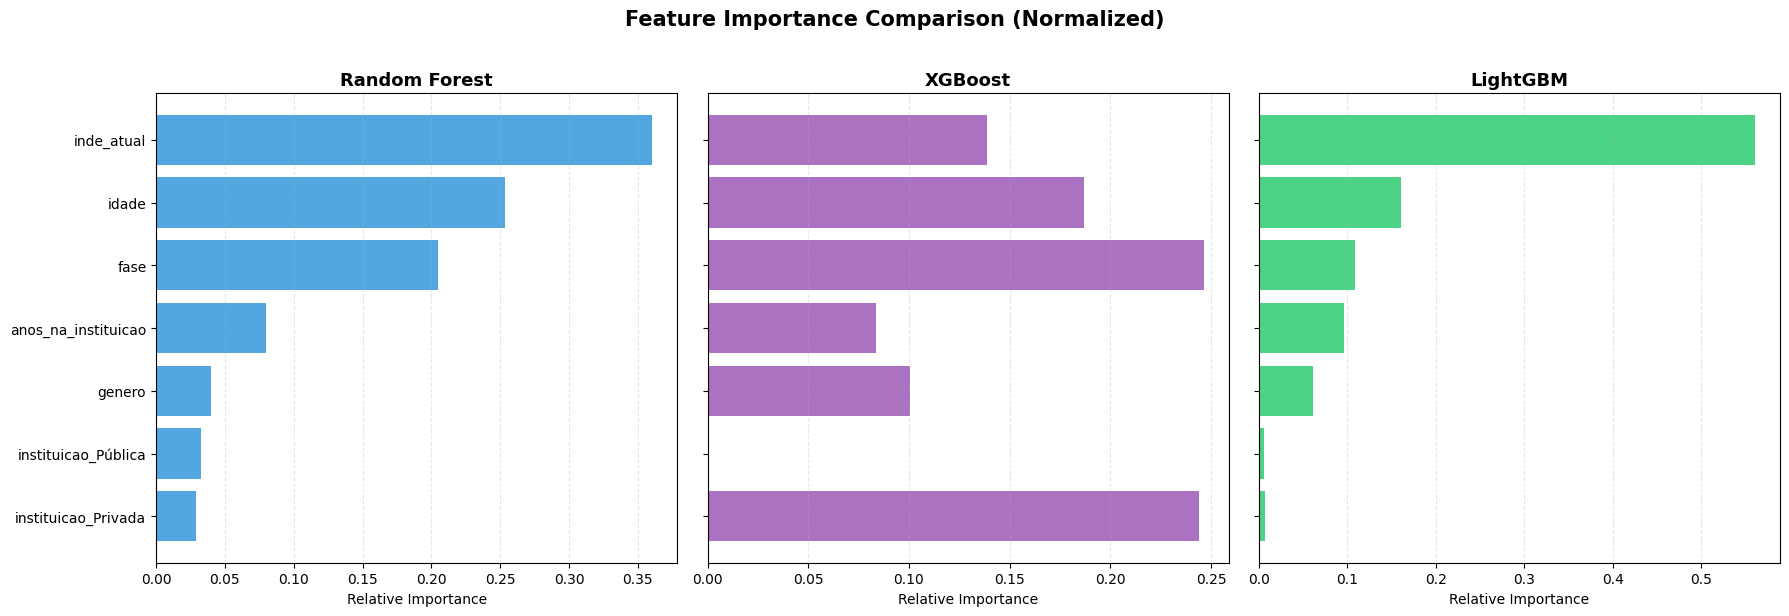

In [15]:
plot_feature_importance({
'Random Forest': rf_results,
'XGBoost': xgb_results,
'LightGBM': lgb_results,
})

Both `RandomForestClassifier` and `LGBMClassifier` display a similar feature importance rank, with `inde_atual`, `idade`, and `fase` amont the top 3. The `XGBClassifier` model, however, appears to put more importance in `instituicao_privada`, `fase`, and `idade`.

## Saving Models

We can now fit our pipelines to the entire dataset and save them to `../models` so that it can be used for our API.

In [16]:
# Fitting pipelines to the entire data

print('Fitting Pipelines to X and y...\n')
pipeline_rf.fit(X,y)
pipeline_xgb.fit(X,y)
pipeline_lgbm.fit(X,y)
print("\nModels fit successfully!")

Fitting Pipelines to X and y...


Models fit successfully!


In [17]:
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

joblib.dump(
    pipeline_rf,
    os.path.join(
        models_dir, 'pipeline_rf.joblib'
    )
)

joblib.dump(
    pipeline_xgb,
    os.path.join(
        models_dir, 'pipeline_xgb.joblib'
    )
)

joblib.dump(
    pipeline_lgbm,
    os.path.join(
        models_dir, 'pipeline_lgbm.joblib'
    )
)

print(
    f"Models saved to {models_dir}"
)

Models saved to ../models


---